# Sommaire

### - Extraction et Traitement des données
### - Création du premier CNN
### - Fine-tunning du CNN
### - Re-training du VGG16
### - Comparaison entre notre modèle "Fait-main" et VGG16
### - Etendre notre meilleur modèle maison et le VGG16 au DataFrame entier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import cv2 as cv
import glob
import time
import tensorflow as tf
from tensorflow.python.keras import layers
from keras.layers import Rescaling

%matplotlib inline


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print(cv.getNumberOfCPUs())
print(cv.getNumThreads())
print(tf.test.gpu_device_name())
print(tf.keras.__version__)

16
16
/device:GPU:0
2.9.0


In [4]:
img = cv.imread("C:/Users/antoi/Dropbox/PC/Desktop/Images/n02087046-toy_terrier/n02087046_81.jpg")

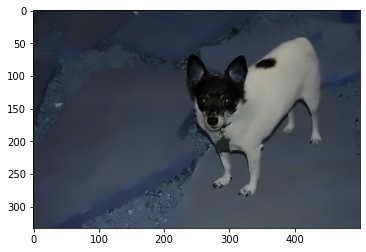

In [5]:
plt.imshow(cv.fastNlMeansDenoisingColored(img,None,10,10,7,21))

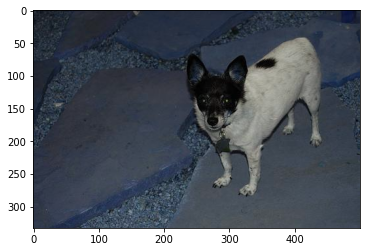

In [6]:
plt.imshow(img)

In [7]:
img.shape

(333, 500, 3)

# Extraction et Traitement des données

## Extraction des données et création du DataFrame.

In [8]:
dim=100

def Extract_Images_Test(Folder):
    temp=[]
    for filename in glob.glob('C:/Users/antoi/Dropbox/PC/Desktop/Images/' + Folder + '/*.jpg'):
        img=cv.imread(filename)
        temp.append([img,(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
    return(pd.DataFrame(temp,columns=['Image','Race']))


def Extract_Images(Folder):
    temp=[]
    for filename in glob.glob('C:/Users/antoi/Dropbox/PC/Desktop/Images/' + Folder + '/*.jpg'):
        img=cv.imread(filename)
        img=cv.resize(img,dsize=[100, 100])
        temp.append([img,(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
        temp.append([cv.flip(img,0),(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
        temp.append([cv.flip(img,1),(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
        temp.append([cv.flip(img,-1),(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
    return(pd.DataFrame(temp,columns=['Image','Race']))

In [9]:
terrier=Extract_Images_Test('n02087046-toy_terrier')

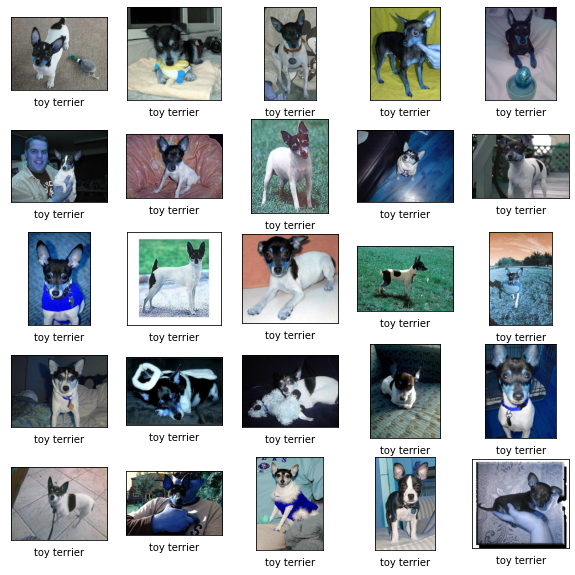

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(terrier['Image'][i])
    plt.xlabel(terrier['Race'][i])
plt.show()

In [11]:
Folders=os.listdir('C:/Users/antoi/Dropbox/PC/Desktop/Images')
print(len(Folders))

120


In [12]:
trackandrep=pd.read_csv('tranckandrep.csv')

In [13]:
num_classes=5

In [14]:
data=pd.DataFrame(columns=['Image','Race','RaceId'],dtype=np.float32)

In [15]:
i=0
for Folder in Folders[:num_classes]:
    tempdata=Extract_Images(Folder)
    data=pd.concat([data,pd.concat([tempdata,pd.DataFrame([i]*(tempdata.shape[0]),columns=['RaceId'])],axis=1)])
    print(i)
    i+=1

0
1
2
3
4


In [16]:
data.reset_index(inplace=True)

In [17]:
data_original=data.copy()

In [18]:
class_names=pd.unique(data['Race'])

In [19]:
data['Grayscale']=data['Image'].apply(lambda x : cv.cvtColor(x,cv.COLOR_BGR2GRAY))

In [20]:
data['Grayscale']=data['Grayscale'].apply(lambda x : cv.convertScaleAbs(cv.equalizeHist(x),alpha=1,beta=10))

In [21]:
print(np.array2string(cv.resize(data['Grayscale'][0],dsize=[30, 30]), max_line_width=150))

[[ 39 139 118  99  85  96 166 195 250 250 246 238 230 225 216 211 202 185 181 178 172 160 145 134 168 195 210 193 194 177]
 [136 126 100 169 171 190 193 244 247 244 235 228 220 212 198 185 178 178 175 164 196 234 203 204 219 185 180 181 210 210]
 [125  96  88 203 164 145 132 237 239 229 222 214 211 193 179 181 174 170 184 226 205 174 158 163 214 228 227 242 184 190]
 [ 90  82 131 181 140 101 121 152 164 228 206 197 245 248 220 176 240 243 201 179 129 103 130 193 206 186 246 246 215 196]
 [ 78 112 156 220 119  89  84 120 123 237 247 251 250 248 251 252 255 247 206 161 117 121 183 166 183 200 184 232 225 115]
 [ 76 149 162 208 126  86  73 120 194 249 248 246 241 235 247 249 251 246 220 175 109 171 249 220  90 169 194 120 105  87]
 [141 158 215 228 160  91 123 108 227 245 241 240 230 227 229 229 235 220 219 202 190 162 198 224  94 158 110 140 110 107]
 [161 226 229 208 163 230 106  89 201 236 250 244 236 216 209 242 230 247 214 152  82  94 128 125  80 167 195 130 108  47]
 [239 227 212 17

Each grayscale image can be visualized as a 100x100 matrix where each pixels is translated into a number from 0 to 255, corresponding to a shade of grey. The scale of grey goes from 0 (which correspond to white) to 255 (corresponds to black).

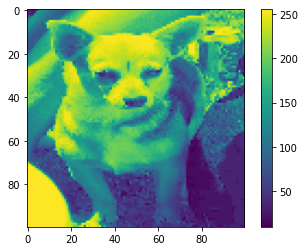

In [22]:
plt.figure()
plt.imshow(data['Grayscale'][0])
plt.colorbar()
plt.grid(False)
plt.show()

In [23]:
for k in range(data['Image'].shape[0]):
    gray=data['Grayscale'][k]
    img=data['Image'][k]
    dst = cv.cornerHarris(gray,2,3,0.04)
    img[dst>0.005*dst.max()]=[255,0,0]

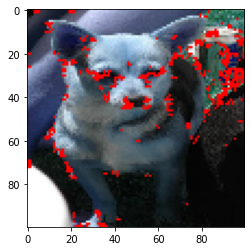

In [24]:
plt.imshow(data['Image'][0])

In [25]:
data['Grayscale']=data['Image'].apply(lambda x : cv.cvtColor(x,cv.COLOR_BGR2GRAY))

In [26]:
data['Grayscale']=data['Grayscale'].apply(lambda x : cv.convertScaleAbs(cv.equalizeHist(x),alpha=1,beta=10))


In [27]:
for k in range(data['Image'].shape[0]):
    gray=data['Grayscale'][k]
    img=data['Image'][k]
    sift = cv.xfeatures2d.SIFT_create()
    kp = sift.detect(img, None)
    img=cv.drawKeypoints(gray,kp,img)

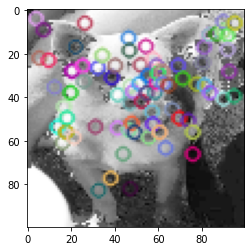

In [28]:
plt.imshow(data['Image'][0])

In [29]:
data['Grayscale']=data['Image'].apply(lambda x : cv.cvtColor(x,cv.COLOR_BGR2GRAY))

In [30]:
data['Grayscale']=data['Grayscale'].apply(lambda x : cv.convertScaleAbs(cv.equalizeHist(x),alpha=1,beta=10))

## Pre processing of the data

In [31]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LayerNormalization
from tensorflow.keras import losses, optimizers
from tensorflow.keras import activations
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


In [32]:
train_image,test_image,train_label, test_label = train_test_split(data.loc[:,['Image','Grayscale']],data.loc[:,['Race','RaceId']],stratify=data['RaceId'],test_size=0.1)

<AxesSubplot:xlabel='class', ylabel='prop'>

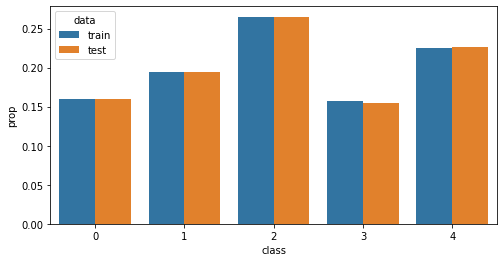

In [33]:
y_counts = pd.DataFrame({
    'data': np.array(['train'] * num_classes + ['test'] * num_classes),
    'class': np.tile(np.arange(num_classes), 2),
    'prop': np.hstack([np.bincount(train_label['RaceId']) / train_label.shape[0],
                         np.bincount(test_label['RaceId']) / test_label.shape[0]])
})

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='class', y='prop', hue='data', data=y_counts, ax=ax)

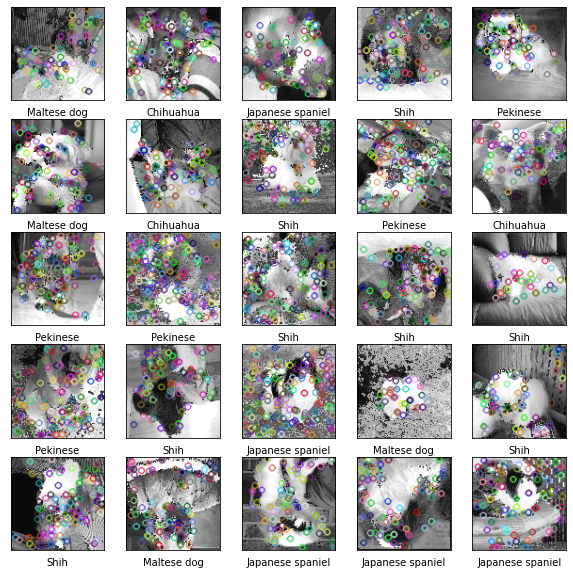

In [34]:
plt.figure(figsize=(10,10))
k=0
for i in train_image.index[:25]:
    plt.subplot(5,5,k+1)
    k+=1
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_image['Image'][i])
    plt.xlabel(train_label['Race'][i])
plt.show()

We normalize the data:

In [35]:
train_images = train_image['Image']
test_images = test_image['Image']

train_labels=train_label['RaceId']
test_labels=test_label['RaceId']


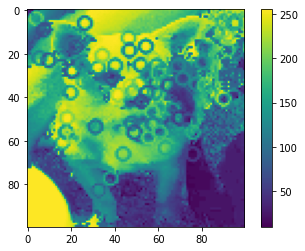

In [36]:
plt.figure()
plt.imshow(data['Grayscale'][0])
plt.colorbar()
plt.grid(False)
plt.show()

The scale of grey is now from 0 to 1.

In [37]:
# convert class vectors to binary class matrices
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)
train_labels[:10]

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [38]:
train_labels.shape

(3427, 5)

In [39]:
test_labels.shape

(381, 5)

###**Creation of a validation set**

We further split the train set into a train and validation set. The validation set will be 20% from the original train set, therefore the split will be train/validation of 0.8/0.2.

The actual training set will be divided into two groups:
* the training set
* the validation set

In [40]:

train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=2020)

In [41]:
train_id=train_image.index
valid_id=valid_images.index
test_id=test_image.index


In [42]:
partition = {'train' : [str(i) for i in train_id], 'validation' : [str(i) for i in valid_id]}

labels={}
for i in train_id:
    labels[str(i)]=train_labels
for i in valid_id:
    labels[str(i)]=valid_labels

In [43]:
train_images=np.asarray([i.astype(np.float32) for i in train_images])
train_labels=np.asarray([i.astype(np.float32) for i in train_labels])

valid_images=np.asarray([i.astype(np.float32) for i in valid_images])
valid_labels=np.asarray([i.astype(np.float32) for i in valid_labels])

test_images=np.asarray([i.astype(np.float32) for i in test_images])
test_labels=np.asarray([i.astype(np.float32) for i in test_labels])

In [44]:
valid_set= (valid_images,valid_labels)

Now that we are familiar with the data, let's dive into the real work: building a neural network that will be able to classify accurately new clothes images.

In this section, we are going to try to create the most efficient CNN by modifying the architecture of the model but also hyperparameters.

In [45]:
tandrep=pd.DataFrame(columns=['Model','Act Func','Trainset Ids','Testset Ids','Validset Ids','Results','Calc Time'])

# Création du premier CNN

In [46]:
batch_size = 32
epochs = 40

In [47]:

input_shape = train_images.shape[1:]


model_cnn = Sequential()
model_cnn.add(Conv2D(16, kernel_size=5, activation='relu', input_shape=input_shape, name='conv2d_1'))
model_cnn.add(Conv2D(32, kernel_size=4, activation='relu', name='conv2d_2'))
model_cnn.add(MaxPooling2D(pool_size=2, name='max_pool_1'))
model_cnn.add(Dropout(0.25, name='dropout_1'))
model_cnn.add(Conv2D(32, kernel_size=3, activation='relu', name='conv2d_3'))
model_cnn.add(MaxPooling2D(pool_size=2, name='max_pool_2'))
model_cnn.add(Dropout(0.25, name='dropout_2'))
model_cnn.add(Flatten(name='flatten'))
model_cnn.add(Dense(50, activation='relu', name='dense'))
model_cnn.add(Dense(num_classes, activation='softmax', name='output'))

model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 96, 96, 16)        1216      
                                                                 
 conv2d_2 (Conv2D)           (None, 93, 93, 32)        8224      
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 46, 46, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 46, 46, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 22, 22, 32)        0         
                                                                 
 dropout_2 (Dropout)         (None, 22, 22, 32)        0

In [48]:

# Run the train
time0=time.time()
history_cnn = model_cnn.fit(train_images, train_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=valid_set)


score_cnn = model_cnn.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score_cnn[0])
print('Test accuracy:', score_cnn[1])
time1=time.time()-time0

Epoch 1/40
86/86 [==============================] - 8s 12ms/step - loss: 13.2869 - accuracy: 0.2269 - val_loss: 1.6076 - val_accuracy: 0.2682

In [49]:
trackandrep=pd.concat([trackandrep,pd.DataFrame([[model_cnn,'mirroring, whitening(alpha=1,beta=10), contrast, equalizing, débruitage, redimensionnement(100*100)',"model_cnn = Sequential() model_cnn.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=input_shape, name='conv2d_1')) model_cnn.add(Conv2D(128, kernel_size=(5, 5), activation='relu', name='conv2d_2')) model_cnn.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_1')) model_cnn.add(Dropout(0.25, name='dropout_1')) model_cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv2d_3')) model_cnn.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_2')) model_cnn.add(Dropout(0.25, name='dropout_2')) model_cnn.add(Flatten(name='flatten')) model_cnn.add(Dense(256, activation='relu', name='dense')) model_cnn.add(Dense(num_classes, activation='softmax', name='output')) model_cnn.compile(loss=losses.categorical_crossentropy,optimizer=optimizers.Adadelta(),metrics=['accuracy'])",'relu',train_image.index,test_image.index,'Accuracy',score_cnn[1],str(np.round(time1,0)) + 's']],columns=['Model','Image Filtering','Parametres+Layers','Act Func','Trainset Ids','Testset Ids','Metric','Results','Calc Time'])])

tandrep=tandrep.append({'Model':model_cnn,'Act Func':'relu','Trainset Ids':train_id,'Testset Ids':test_id,'Validset Ids':valid_id,'Results':score_cnn[1],'Calc Time':str(time1)+'s'},ignore_index=True)

C:\Users\antoi\AppData\Local\Temp\ipykernel_6304\3935953490.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tandrep=tandrep.append({'Model':model_cnn,'Act Func':'relu','Trainset Ids':train_id,'Testset Ids':test_id,'Validset Ids':valid_id,'Results':score_cnn[1],'Calc Time':str(time1)+'s'},ignore_index=True)


# Fine-tunning du CNN

**Comment on the first neural network**

The accuracy level on the training set is quite low. With epochs=20, we see that the level of accuracy still increases. However, increasing the epochs hyperparameter is time-consuming for only small improvement in accuracy.

Instead, we are going to focus first on the kernel size used.

### **Second version of the CNN: changing the kernel size**

In [50]:
time0=time.time()
model_cnn2 = Sequential()
model_cnn2.add(Conv2D(16, kernel_size=10, activation='relu', input_shape=input_shape, name='conv2d_1'))
model_cnn2.add(Conv2D(32, kernel_size=8, activation='relu', name='conv2d_2'))
model_cnn2.add(MaxPooling2D(pool_size=2, name='max_pool_1'))
model_cnn2.add(Dropout(0.25, name='dropout_1'))
model_cnn2.add(Conv2D(32, kernel_size=6, activation='relu', name='conv2d_3'))
model_cnn2.add(MaxPooling2D(pool_size=2, name='max_pool_2'))
model_cnn2.add(Dropout(0.25, name='dropout_2'))
model_cnn2.add(Flatten(name='flatten'))
model_cnn2.add(Dense(50, activation='relu', name='dense'))
model_cnn2.add(Dense(num_classes, activation='softmax', name='output'))

model_cnn2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_cnn2.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 91, 91, 16)        4816      
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 32)        32800     
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 42, 42, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 42, 42, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 32)        36896     
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 18, 18, 32)        0         
                                                                 
 dropout_2 (Dropout)         (None, 18, 18, 32)       

In [51]:

# Run the train
history_cnn2 = model_cnn2.fit(train_images, train_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=valid_set)
score_cnn2 = model_cnn2.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score_cnn2[0])
print('Test accuracy:', score_cnn2[1])
time1=time.time()-time0

Epoch 1/40
86/86 [==============================] - 2s 14ms/step - loss: 6.4398 - accuracy: 0.2536 - val_loss: 1.6013 - val_accuracy: 0.2682

In [52]:
trackandrep=pd.concat([trackandrep,pd.DataFrame([[model_cnn2,'mirroring, whitening(alpha=1,beta=10), contrast, equalizing, débruitage, redimensionnement(100*100)',"model_cnn2 = Sequential() model_cnn2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='conv2d_1')) model_cnn2.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv2d_2')) model_cnn2.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_1')) model_cnn2.add(Dropout(0.25, name='dropout_1')) model_cnn2.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv2d_3')) model_cnn2.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_2')) model_cnn2.add(Dropout(0.25, name='dropout_2')) model_cnn2.add(Flatten(name='flatten')) model_cnn2.add(Dense(256, activation='relu', name='dense')) model_cnn2.add(Dense(num_classes, activation='softmax', name='output')) model_cnn2.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adadelta(), metrics=['accuracy'])",'relu',train_image.index,test_image.index,'Accuracy',score_cnn[1],str(np.round(time1,0)) + 's']],columns=['Model','Image Filtering','Parametres+Layers','Act Func','Trainset Ids','Testset Ids','Metric','Results','Calc Time'])])

tandrep=tandrep.append({'Model':model_cnn2,'Act Func':'relu','Trainset Ids':train_id,'Testset Ids':test_id,'Validset Ids':valid_id,'Results':score_cnn2[1],'Calc Time':str(time1)+'s'},ignore_index=True)

C:\Users\antoi\AppData\Local\Temp\ipykernel_6304\3011671740.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tandrep=tandrep.append({'Model':model_cnn2,'Act Func':'relu','Trainset Ids':train_id,'Testset Ids':test_id,'Validset Ids':valid_id,'Results':score_cnn2[1],'Calc Time':str(time1)+'s'},ignore_index=True)


The second CNN achieve a slightly better accuracy level, both during training and on testing set.




---



### **3rd version of the CNN: Changing the optimizer and adding rescaling**

Instead of using Adadelta optimizer, we are trying to assess if other optimizers would build better predictive model. We are now using the 'Adam' optimizer.

In [53]:
time0=time.time()
model_cnn3 = Sequential()
model_cnn3.add(Rescaling(1./255, input_shape=input_shape))
model_cnn3.add(Conv2D(16, kernel_size=10, activation='relu', input_shape=input_shape, name='conv2d_1'))
model_cnn3.add(Conv2D(32, kernel_size=8, activation='relu', name='conv2d_2'))
model_cnn3.add(MaxPooling2D(pool_size=2, name='max_pool_1'))
model_cnn3.add(Dropout(0.25, name='dropout_1'))
model_cnn3.add(Conv2D(32, kernel_size=6, activation='relu', name='conv2d_3'))
model_cnn3.add(MaxPooling2D(pool_size=2, name='max_pool_2'))
model_cnn3.add(Dropout(0.25, name='dropout_2'))
model_cnn3.add(Flatten(name='flatten'))
model_cnn3.add(Dense(50, activation='relu', name='dense'))
model_cnn3.add(Dense(num_classes, activation='softmax', name='output'))

model_cnn3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)



In [54]:

# Run the train
history_cnn3 = model_cnn3.fit(train_images, train_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=valid_set)
score_cnn3 = model_cnn3.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score_cnn3[0])
print('Test accuracy:', score_cnn3[1])
time1=time.time()-time0


Epoch 1/40
86/86 [==============================] - 1s 12ms/step - loss: 1.6088 - accuracy: 0.2565 - val_loss: 1.5929 - val_accuracy: 0.2682

In [55]:
trackandrep=pd.concat([trackandrep,pd.DataFrame([[model_cnn3,'mirroring, whitening(alpha=1,beta=10), contrast, equalizing, débruitage, redimensionnement(100*100)',"model_cnn3 = Sequential() model_cnn3.add(Rescaling(1./255, input_shape=input_shape)) model_cnn3.add(Conv2D(16, kernel_size=10, activation='relu', input_shape=input_shape, name='conv2d_1')) model_cnn3.add(Conv2D(32, kernel_size=8, activation='relu', name='conv2d_2')) model_cnn3.add(MaxPooling2D(pool_size=2, name='max_pool_1')) model_cnn3.add(Dropout(0.25, name='dropout_1')) model_cnn3.add(Conv2D(32, kernel_size=6, activation='relu', name='conv2d_3')) model_cnn3.add(MaxPooling2D(pool_size=2, name='max_pool_2')) model_cnn3.add(Dropout(0.25, name='dropout_2')) model_cnn3.add(Flatten(name='flatten')) model_cnn3.add(Dense(50, activation='relu', name='dense')) model_cnn3.add(Dense(num_classes, activation='softmax', name='output')) model_cnn3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],)",'relu',train_image.index,test_image.index,'Accuracy',score_cnn3[1],str(np.round(time1,0)) + 's']],columns=['Model','Image Filtering','Parametres+Layers','Act Func','Trainset Ids','Testset Ids','Metric','Results','Calc Time'])])

tandrep=tandrep.append({'Model':model_cnn3,'Act Func':'relu','Trainset Ids':train_id,'Testset Ids':test_id,'Validset Ids':valid_id,'Results':score_cnn3[1],'Calc Time':str(time1)+'s'},ignore_index=True)

C:\Users\antoi\AppData\Local\Temp\ipykernel_6304\2093022470.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tandrep=tandrep.append({'Model':model_cnn3,'Act Func':'relu','Trainset Ids':train_id,'Testset Ids':test_id,'Validset Ids':valid_id,'Results':score_cnn3[1],'Calc Time':str(time1)+'s'},ignore_index=True)


Adam optimizer increased the accuracy level on the test set. However, the gap between the accuracy on the training (98%) and the testing set illustrates the "over-fitting" phenomenon.

### **4th version of the CNN: Preventing overfitting and adding layers**

In [56]:
time0=time.time()
model_cnn4 = Sequential()
model_cnn4.add(Rescaling(1./255, input_shape=input_shape))
model_cnn4.add(Conv2D(16, kernel_size=10, activation='relu', input_shape=input_shape, name='conv2d_1'))
model_cnn4.add(MaxPooling2D(pool_size=3, name='max_pool_1'))
model_cnn4.add(Conv2D(32, kernel_size=8, activation='relu', name='conv2d_2'))
model_cnn4.add(MaxPooling2D(pool_size=2, name='max_pool_2'))
model_cnn4.add(Dropout(0.25, name='dropout_1'))
model_cnn4.add(Conv2D(32, kernel_size=6, activation='relu', name='conv2d_3'))
model_cnn4.add(MaxPooling2D(pool_size=2, name='max_pool_3'))
model_cnn4.add(Dropout(0.25, name='dropout_2'))
model_cnn4.add(Flatten(name='flatten'))
model_cnn4.add(Dense(50, activation='relu', name='dense'))
model_cnn4.add(Dense(num_classes, activation='softmax', name='output'))

model_cnn4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [57]:
from tensorflow.keras.callbacks import EarlyStopping

In [58]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

# Run the train
history_cnn4 = model_cnn4.fit(train_images, train_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=valid_set,
                            callbacks=[es])
score_cnn4 = model_cnn4.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score_cnn4[0])
print('Test accuracy:', score_cnn4[1])
time1=time.time()-time0

Epoch 1/40
86/86 [==============================] - 1s 9ms/step - loss: 1.6009 - accuracy: 0.2393 - val_loss: 1.5926 - val_accuracy: 0.2595
Epoch 2/40
86/86 [==============================] - 1s 7ms/step - loss: 1.5870 - acc

In [59]:
trackandrep=pd.concat([trackandrep,pd.DataFrame([[model_cnn4,'mirroring, whitening(alpha=1,beta=10), contrast, equalizing, débruitage, redimensionnement(100*100)',"model_cnn2 = Sequential() model_cnn2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='conv2d_1')) model_cnn2.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv2d_2')) model_cnn2.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_1')) model_cnn2.add(Dropout(0.5, name='dropout_1')) model_cnn2.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv2d_3')) model_cnn2.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_2')) model_cnn2.add(Dropout(0.5, name='dropout_2')) model_cnn2.add(Flatten(name='flatten')) model_cnn2.add(Dense(256, activation='relu', name='dense')) model_cnn2.add(Dense(num_classes, activation='softmax', name='output')) model_cnn2.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adadelta(), metrics=['accuracy'])",'relu',train_image.index,test_image.index,'Accuracy',score_cnn[1],str(np.round(time1,0)) + 's']],columns=['Model','Image Filtering','Parametres+Layers','Act Func','Trainset Ids','Testset Ids','Metric','Results','Calc Time'])])

tandrep=tandrep.append({'Model':model_cnn4,'Act Func':'relu','Trainset Ids':train_id,'Testset Ids':test_id,'Validset Ids':valid_id,'Results':score_cnn4[1],'Calc Time':str(time1)+'s'},ignore_index=True)

C:\Users\antoi\AppData\Local\Temp\ipykernel_6304\3799959991.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tandrep=tandrep.append({'Model':model_cnn4,'Act Func':'relu','Trainset Ids':train_id,'Testset Ids':test_id,'Validset Ids':valid_id,'Results':score_cnn4[1],'Calc Time':str(time1)+'s'},ignore_index=True)


*Remarks:*

We run the same models with different "batch_size" (10, 64, 128) and noticed that:
* for the firsts CNNs, a small batch_size led to better accuracy levels.
* However, for the last ones (which have been otpimized from the previous ones), changing the batch size didn't have a significant effect on the accuracy level.


### **5th version of the CNN: Fine-tuning and trials**

In [60]:

time0=time.time()
model_cnn5 = Sequential()
model_cnn5.add(Rescaling(1./255, input_shape=input_shape))
model_cnn5.add(LayerNormalization())
model_cnn5.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model_cnn5.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model_cnn5.add(MaxPooling2D(pool_size=(3,3)))

model_cnn5.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_cnn5.add(MaxPooling2D(pool_size=(3,3)))

model_cnn5.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_cnn5.add(MaxPooling2D(pool_size=(3,3)))



model_cnn5.add(Flatten())
model_cnn5.add(Dense(num_classes*10, activation='relu'))
model_cnn5.add(Dropout(0.1))
model_cnn5.add(Dense(num_classes, activation='softmax'))

model_cnn5.compile(
   optimizer='adam',
   loss='categorical_crossentropy',
   metrics=['accuracy'],
)


model_cnn5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 layer_normalization (LayerN  (None, 100, 100, 3)      6         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)       

In [61]:
# Run the train
history_cnn5 = model_cnn5.fit(train_images, train_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=valid_set,
                            callbacks=[es])

Epoch 1/40
86/86 [==============================] - 2s 20ms/step - loss: 1.5947 - accuracy: 0.2660 - val_loss: 1.5854 - val_accuracy: 0.2682

In [62]:
score_cnn5 = model_cnn5.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score_cnn5[0])
print('Test accuracy:', score_cnn5[1])
time1=time.time()-time0

Test loss: 1.520027756690979
Test accuracy: 0.3648293912410736


In [63]:
trackandrep=pd.concat([trackandrep,pd.DataFrame([[model_cnn5,'mirroring, whitening(alpha=1,beta=10), contrast, equalizing, débruitage, redimensionnement(100*100)',"cnn5 = Sequential() cnn5.add(Rescaling(1./255, input_shape=input_shape)) cnn5.add(Conv2D(16, kernel_size=10, activation='relu')) cnn5.add(MaxPooling2D(3)) cnn5.add(Conv2D(32, kernel_size=8, activation='relu')) cnn5.add(MaxPooling2D(2)) cnn5.add(Conv2D(32, kernel_size=6, activation='relu')) cnn5.add(MaxPooling2D(2)) cnn5.add(Flatten()) cnn5.add(Dense(50, activation='relu')) cnn5.add(Dense(20, activation='relu')) cnn5.add(Dense(5, activation='softmax')) cnn5.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],)",'relu',train_image.index,test_image.index,'Accuracy',score_cnn5[1],str(np.round(time1,0)) + 's']],columns=['Model','Image Filtering','Parametres+Layers','Act Func','Trainset Ids','Testset Ids','Metric','Results','Calc Time'])])

tandrep=tandrep.append({'Model':model_cnn5,'Act Func':'relu','Trainset Ids':train_id,'Testset Ids':test_id,'Validset Ids':valid_id,'Results':score_cnn5[1],'Calc Time':str(time1)+'s'},ignore_index=True)



C:\Users\antoi\AppData\Local\Temp\ipykernel_6304\1278110858.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tandrep=tandrep.append({'Model':model_cnn5,'Act Func':'relu','Trainset Ids':train_id,'Testset Ids':test_id,'Validset Ids':valid_id,'Results':score_cnn5[1],'Calc Time':str(time1)+'s'},ignore_index=True)


# Re-training du VGG16

In [64]:
from keras.applications import VGG16
from tensorflow.python.keras import models

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = False ## Not trainable weights


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(num_classes*10, activation='relu')
dense_layer_2 = layers.Dense(num_classes*5, activation='relu')
dropout_layer = layers.Dropout(0.1)
prediction_layer = layers.Dense(num_classes, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer,
    dense_layer_2,
    prediction_layer
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

history_model=model.fit(train_images, train_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=valid_set,
                            callbacks=[es])

Epoch 1/40
86/86 [==============================] - 3s 26ms/step - loss: 2.8152 - accuracy: 0.2401 - val_loss: 1.5991 - val_accuracy: 0.2434

In [65]:
score_model = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score_model[0])
print('Test accuracy:', score_model[1])

Test loss: 2.274533748626709
Test accuracy: 0.42257216572761536


In [66]:
tandrep=tandrep.append({'Model':model,'Act Func':'relu','Trainset Ids':train_id,'Testset Ids':test_id,'Validset Ids':valid_id,'Results':score_model[1],'Calc Time':str(time1)+'s'},ignore_index=True)

C:\Users\antoi\AppData\Local\Temp\ipykernel_6304\1688923381.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tandrep=tandrep.append({'Model':model,'Act Func':'relu','Trainset Ids':train_id,'Testset Ids':test_id,'Validset Ids':valid_id,'Results':score_model[1],'Calc Time':str(time1)+'s'},ignore_index=True)


In [67]:
trackandrep


Unnamed: 0.15  Unnamed: 0.14  Unnamed: 0.13  Unnamed: 0.12  Unnamed: 0.11  \
0             0.0            0.0            0.0            0.0            0.0   
1             1.0            1.0            1.0            1.0            1.0   
2             2.0            2.0            2.0            2.0            2.0   
3             3.0            3.0            3.0            3.0            3.0   
4             4.0            4.0            4.0            4.0            4.0   
..            ...            ...            ...            ...            ...   
0             NaN            NaN            NaN            NaN            NaN   
0             NaN            NaN            NaN            NaN            NaN   
0             NaN            NaN            NaN            NaN            NaN   
0             NaN            NaN            NaN            NaN            NaN   
0             NaN            NaN            NaN            NaN            NaN   

    Unnamed: 0.10  Unnamed: 0.9  Unnamed: 0.8  Unnamed: 0.7  Unnamed: 0.6  \
0             0.0           0.0           0.0           0.0           0.0   
1             1.0           1.0           1.0           1.0           1.0   
2             2.0           2.0           2.0           2.0           2.0   
3             3.0           3.0           3.0           3.0           3.0   
4             4.0           4.0           4.0           4.0           4.0   
..            ...           ...           ...           ...           ...   
0             NaN           NaN           NaN           NaN           NaN   
0             NaN           NaN           NaN           NaN           NaN   
0             NaN           NaN           NaN           NaN           NaN   
0             NaN           NaN           NaN           NaN           NaN   
0             NaN           NaN           NaN           NaN           NaN   

    ...  level_0                                              Model  \
0   ...      0.0  <keras.engine.sequential.Sequential object at ...   
1   ...      1.0  <keras.engine.sequential.Sequential object at ...   
2   ...      2.0  <keras.engine.sequential.Sequential object at ...   
3   ...      3.0  <keras.engine.sequential.Sequential object at ...   
4   ...      4.0  <keras.engine.sequential.Sequential object at ...   
..  ...      ...                                                ...   
0   ...      NaN  <keras.engine.sequential.Sequential object at ...   
0   ...      NaN  <keras.engine.sequential.Sequential object at ...   
0   ...      NaN  <keras.engine.sequential.Sequential object at ...   
0   ...      NaN  <keras.engine.sequential.Sequential object at ...   
0   ...      NaN  <keras.engine.sequential.Sequential object at ...   

                                      Image Filtering  \
0   mirroring, whitening(alpha=1,beta=10), contras...   
1   mirroring, whitening(alpha=1,beta=10), contras...   
2   mirroring, whitening(alpha=1,beta=10), contras...   
3   mirroring, whitening(alpha=1,beta=10), contras...   
4   mirroring, whitening(alpha=1,beta=10), contras...   
..                                                ...   
0   mirroring, whitening(alpha=1,beta=10), contras...   
0   mirroring, whitening(alpha=1,beta=10), contras...   
0   mirroring, whitening(alpha=1,beta=10), contras...   
0   mirroring, whitening(alpha=1,beta=10), contras...   
0   mirroring, whitening(alpha=1,beta=10), contras...   

                                    Parametres+Layers  Act Func  \
0   model_cnn = Sequential() model_cnn.add(Conv2D(...      relu   
1   model_cnn2 = Sequential() model_cnn2.add(Conv2...      relu   
2   model_cnn2 = Sequential() model_cnn2.add(Conv2...      relu   
3   model_cnn2 = Sequential() model_cnn2.add(Conv2...      relu   
4   model_cnn = Sequential() model_cnn.add(Conv2D(...      relu   
..                                                ...       ...   
0   model_cnn = Sequential() model_cnn.add(Conv2D(...      relu   
0   model_cnn2 = Sequential() mo

In [68]:
trackandrep.to_csv('tranckandrep.csv')

# Comparaison entre notre modèle "Fait-main" et VGG16



### Comparaison of accuracy and loss

In [ ]:
# summarize history for accuracy

def history_accuracy(history_model):
  history = history_model
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
# summarize history for loss

def history_loss(history_model):
  history = history_model
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()



FIRST CNN MODEL:


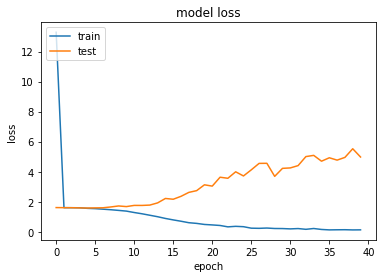

2ND CNN MODEL :


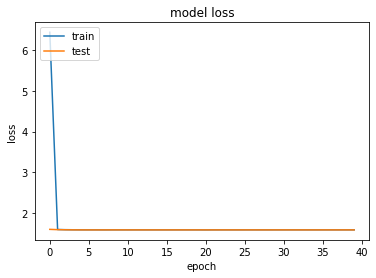

3RD CNN MODEL:


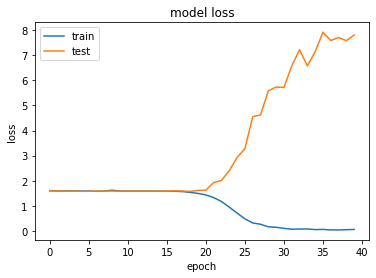

4TH CNN MODEL: 


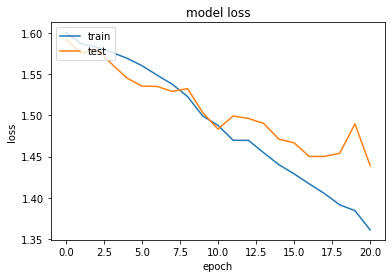

5th CNN MODEL:


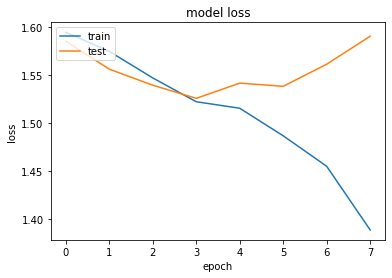

VGG16 MODEL: 


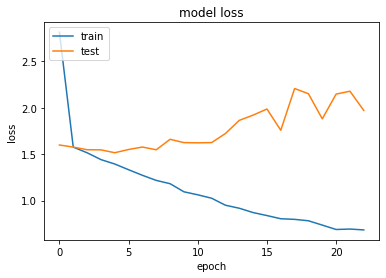

In [70]:
#Loss
print("FIRST CNN MODEL:" )
history_loss(history_cnn)
print("2ND CNN MODEL :")
history_loss(history_cnn2)
print("3RD CNN MODEL:")
history_loss(history_cnn3)
print("4TH CNN MODEL: ")
history_loss(history_cnn4)
print("5th CNN MODEL:")
history_loss(history_cnn5)
print("VGG16 MODEL: ")
history_loss(history_model)

The lower the loss, the better a model. The loss is calculated on training and validation and its interperation is how well the model is doing for these two sets. Unlike accuracy, loss is not a percentage. It is a summation of the errors made for each example in training or validation sets. In the case of neural networks, the loss is usually negative log-likelihood and residual sum of squares for classification and regression respectively.

By increasing the number of epochs, the loss would have probably continue to decrease for the 1st nd 2nd CNN. However, it stays at 1st a higher lever for those models than the last one.
We note that the 3rd CNN's loss function of the test set diverges from the loss function of the train set. One would expect the reduction of loss after each, or several, iterations, which is clearly not the case for this model's test set.

The first and second models achieve lower accuracy level. However, the train and test accuracy levels are close enough to conclude that there is no overfitting.
Overfitting is clearly observed in the 3rd model, and largely reduced in the 4th one.

FIRST CNN MODEL:


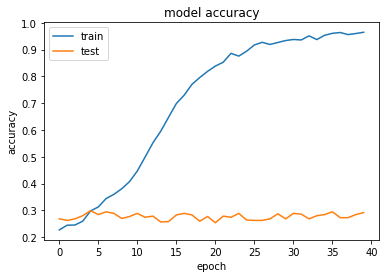

2ND CNN MODEL :


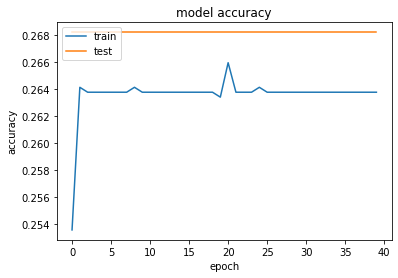

3RD CNN MODEL:


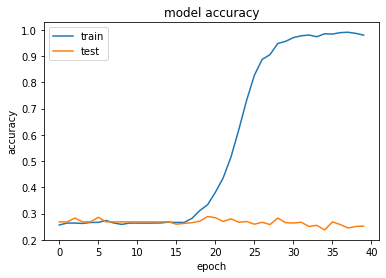

4TH CNN MODEL: 


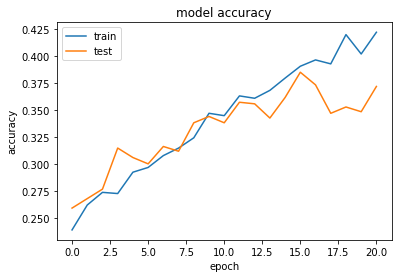

5TH CNN MODEL: 


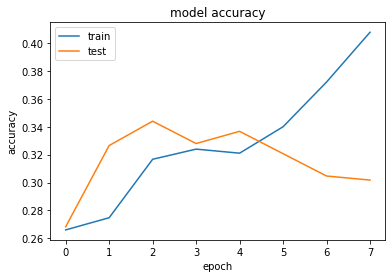

VGG16 MODEL: 


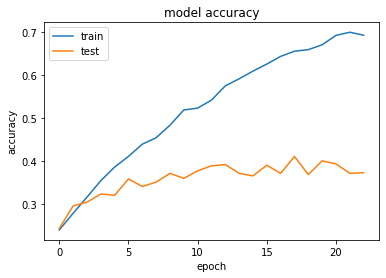

In [71]:
# Accuracy
print("FIRST CNN MODEL:" )
history_accuracy(history_cnn)
print("2ND CNN MODEL :")
history_accuracy(history_cnn2)
print("3RD CNN MODEL:")
history_accuracy(history_cnn3)
print("4TH CNN MODEL: ")
history_accuracy(history_cnn4)
print("5TH CNN MODEL: ")
history_accuracy(history_cnn5)
print("VGG16 MODEL: ")
history_accuracy(history_model)


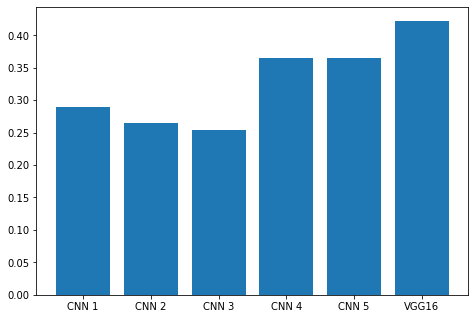

In [72]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
CNN = ['CNN 1', 'CNN 2', 'CNN 3', 'CNN 4','CNN 5', 'VGG16']
Test_Accuracy = [score_cnn[1],score_cnn2[1],score_cnn3[1],score_cnn4[1],score_cnn5[1],score_model[1]]
ax.bar(CNN,Test_Accuracy)
plt.show()

### II. B. Which dogs are the harder to classify ?

In [73]:
def plot_image(i, predictions_array, true_label, img):
    true_label_temp, img_temp = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img_temp)

    predicted_label = np.argmax(predictions_array)
    true_label2=np.argmax(true_label_temp)
    if predicted_label == np.argmax(true_label_temp):
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label2]),
                                color=color)



def plot_value_array(i, predictions_array, true_label):
    true_label_temp = true_label[i]
    plt.grid(False)
    plt.xticks(range(num_classes))
    plt.yticks([])
    thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    true_label2=np.argmax(true_label_temp)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label2].set_color('blue')

In [74]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
def plot_prediction_images(prediction):
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range (num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, prediction[i], test_labels, test_images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, prediction[i], test_labels)
    plt.tight_layout()
    plt.show()


### 1st CNN predictions

In [75]:
import tensorflow

probability_model1 = tensorflow.keras.Sequential([model_cnn,
                                         tensorflow.keras.layers.Softmax()])
predictions = probability_model1.predict(test_images)

12/12 [==============================] - 0s 2ms/step


In [76]:
predictions

array([[0.15827066, 0.15828477, 0.29218668, 0.15834358, 0.23291431],
       [0.2185626 , 0.16900279, 0.23956974, 0.18871322, 0.18415165],
       [0.1489562 , 0.1489562 , 0.403749  , 0.14931843, 0.14902024],
       ...,
       [0.14956068, 0.14962195, 0.14982446, 0.1494497 , 0.40154323],
       [0.1504795 , 0.1504792 , 0.39123186, 0.15733023, 0.1504792 ],
       [0.16625737, 0.16075544, 0.22268525, 0.17088589, 0.27941605]],
      dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

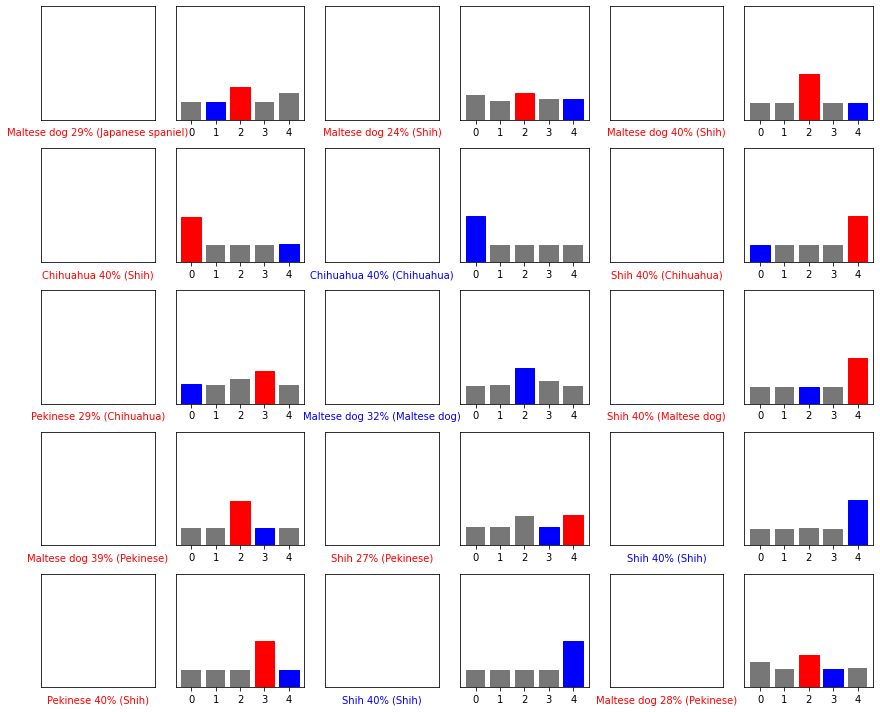

In [77]:
plot_prediction_images(predictions)

### 4th CNN predictions

12/12 [==============================] - 0s 3ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

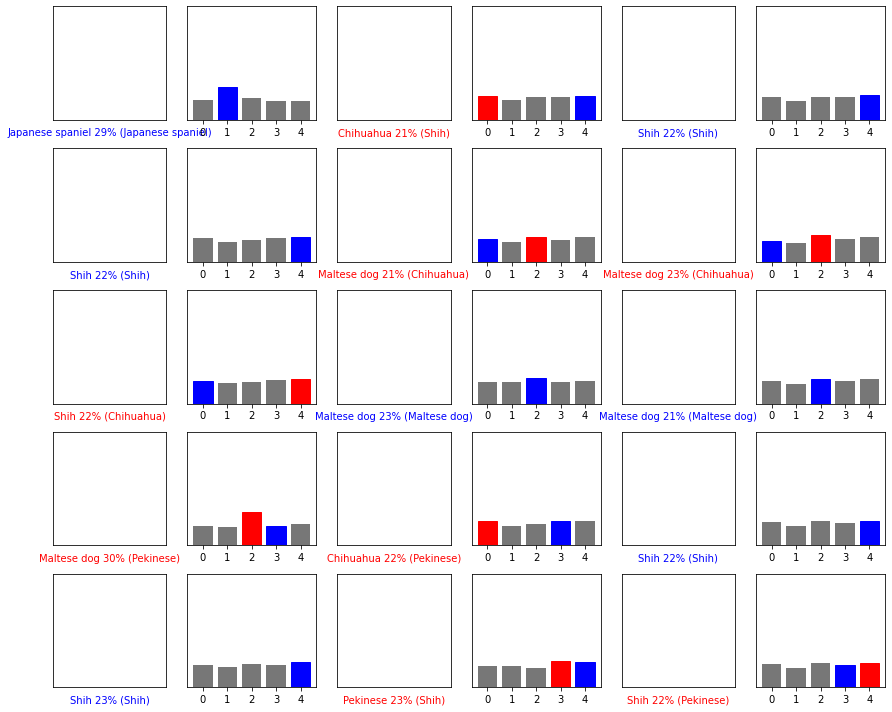

In [78]:
probability_model4 = tensorflow.keras.Sequential([model_cnn4,
                                         tensorflow.keras.layers.Softmax()])
predictions4 = probability_model4.predict(test_images)
plot_prediction_images(predictions4)

### 5th CNN predictions

12/12 [==============================] - 0s 23ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

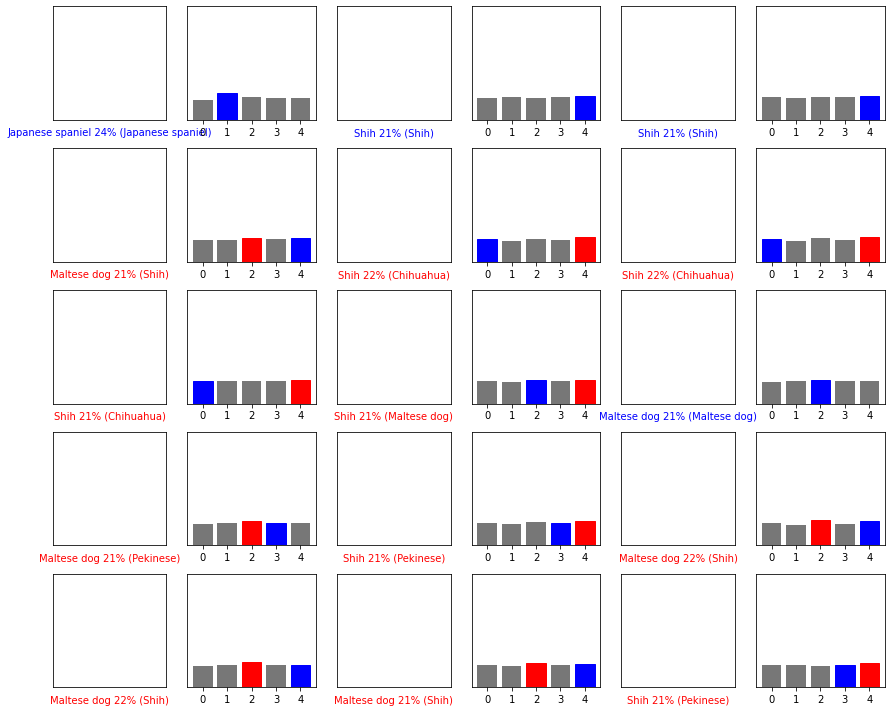

In [79]:
probability_model5 = tensorflow.keras.Sequential([model_cnn5,
                                         tensorflow.keras.layers.Softmax()])
predictions5 = probability_model5.predict(test_images)
plot_prediction_images(predictions5)

### VGG16 predictions

12/12 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

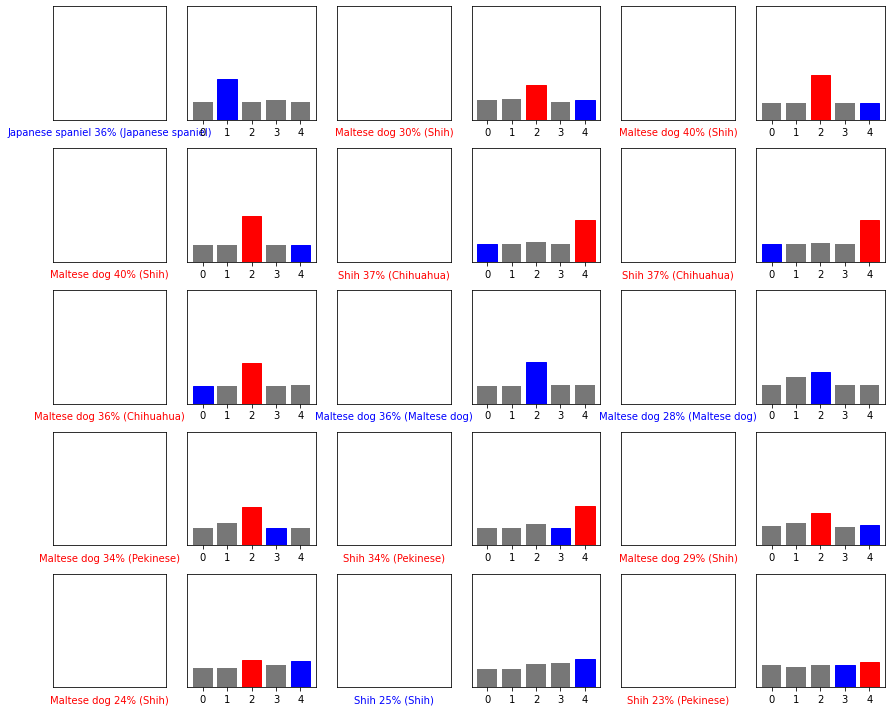

In [80]:
probability_model = tensorflow.keras.Sequential([model,
                                         tensorflow.keras.layers.Softmax()])
predictions_vgg = probability_model.predict(test_images)
plot_prediction_images(predictions_vgg)

In [81]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)

  if normalize:  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [82]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

12/12 [==============================] - 0s 3ms/step


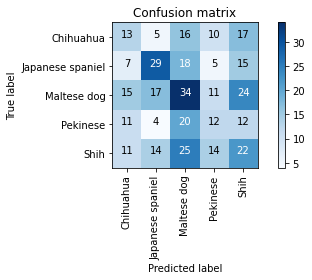

In [83]:
# Predict the values from the validation dataset
Y_pred = model_cnn.predict(test_images)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_labels,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = class_names)


12/12 [==============================] - 0s 2ms/step


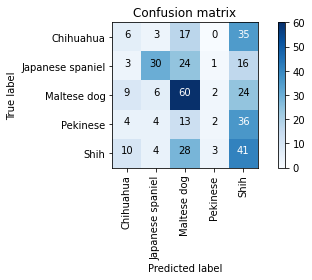

In [84]:
# Predict the values from the validation dataset
Y_pred = model_cnn4.predict(test_images)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_labels,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = class_names)


# **Extending the models to the whole DataFrame**


In [85]:
num_classes=120

In [86]:
data=pd.DataFrame(columns=['Image','Race','RaceId'],dtype=np.float32)

In [87]:
i=0
for Folder in Folders[:num_classes]:
    tempdata=Extract_Images(Folder)
    data=pd.concat([data,pd.concat([tempdata,pd.DataFrame([i]*(tempdata.shape[0]),columns=['RaceId'])],axis=1)])
    i+=1

In [88]:
data.reset_index(inplace=True)

In [89]:
class_names=pd.unique(data['Race'])

In [90]:
data['Grayscale']=data['Image'].apply(lambda x : cv.cvtColor(x,cv.COLOR_BGR2GRAY))
data_original=data.copy()

In [91]:
data['Grayscale']=data['Grayscale'].apply(lambda x : cv.convertScaleAbs(cv.equalizeHist(x),alpha=1,beta=10))

In [92]:
for k in range(data['Image'].shape[0]):
    gray=data['Grayscale'][k]
    img=data['Image'][k]
    dst = cv.cornerHarris(gray,2,3,0.04)
    img[dst>0.005*dst.max()]=[255,0,0]
    if k%10000==0:
        print(k)

0
10000
20000
30000
40000
50000
60000
70000
80000


In [93]:
data['Grayscale']=data['Image'].apply(lambda x : cv.cvtColor(x,cv.COLOR_BGR2GRAY))

In [94]:
data['Grayscale']=data['Grayscale'].apply(lambda x : cv.convertScaleAbs(cv.equalizeHist(x),alpha=1,beta=10))


## Pre processing of the data

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LayerNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split



In [ ]:
train_image,test_image,train_label, test_label = train_test_split(data.loc[:,['Image','Grayscale']],data.loc[:,['Race','RaceId']],stratify=data['RaceId'],test_size=0.1)

In [ ]:
y_counts = pd.DataFrame({
    'data': np.array(['train'] * num_classes + ['test'] * num_classes),
    'class': np.tile(np.arange(num_classes), 2),
    'prop': np.hstack([np.bincount(train_label['RaceId']) / train_label.shape[0],
                         np.bincount(test_label['RaceId']) / test_label.shape[0]])
})

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='class', y='prop', hue='data', data=y_counts, ax=ax)

In [ ]:
plt.figure(figsize=(10,10))
k=0
for i in train_image.index[:25]:
    plt.subplot(5,5,k+1)
    k+=1
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_image['Image'][i])
    plt.xlabel(train_label['Race'][i])
plt.show()

We normalize the data:

In [ ]:
train_images = train_image['Image']
test_images = test_image['Image']

train_labels=train_label['RaceId']
test_labels=test_label['RaceId']

The scale of grey is now from 0 to 1.

In [ ]:
train_labels.shape

In [ ]:
test_labels.shape

###**Creation of a validation set**

We further split the train set into a train and validation set. The validation set will be 20% from the original train set, therefore the split will be train/validation of 0.8/0.2.

The actual training set will be divided into two groups:
* the training set
* the validation set

In [ ]:

train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=2020)

In [ ]:
train_id=train_images.index
valid_id=valid_images.index
test_id=test_images.index

In [ ]:
partition = {'train' : [str(i) for i in train_id], 'validation' : [str(i) for i in valid_id]}

labels={}
for i in train_id:
    labels[str(i)]=train_labels[i]
for i in valid_id:
    labels[str(i)]=valid_labels[i]


### We define a class used not to overflow our GPU.

In [ ]:
batch_size=256
epochs=200

In [ ]:
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=batch_size, dim=input_shape, n_classes=num_classes, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = data['Image'][int(ID)]

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
train_images=np.asarray([i.astype(np.float32) for i in train_images])

valid_images=np.asarray([i.astype(np.float32) for i in valid_images])

test_images=np.asarray([i.astype(np.float32) for i in test_images])

In [ ]:
test_labels = to_categorical(test_labels, num_classes)
test_labels=np.asarray([i.astype(np.float32) for i in test_labels])

In [ ]:
#Generators

training_generator = DataGenerator(partition['train'], labels)
validation_generator = DataGenerator(partition['validation'], labels)

In [110]:
time0=time.time()
wholemodel_cnn = Sequential()
wholemodel_cnn.add(Rescaling(1./255, input_shape=input_shape))
wholemodel_cnn.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
wholemodel_cnn.add(LayerNormalization())
wholemodel_cnn.add(MaxPooling2D(pool_size=3))

wholemodel_cnn.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
wholemodel_cnn.add(MaxPooling2D(pool_size=2))

wholemodel_cnn.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
wholemodel_cnn.add(MaxPooling2D(pool_size=2))

wholemodel_cnn.add(Flatten(name='flatten'))
wholemodel_cnn.add(Dense(num_classes*10, activation='relu'))
wholemodel_cnn.add(Dense(num_classes*5, activation='relu'))
wholemodel_cnn.add(Dropout(0.5))
wholemodel_cnn.add(Dense(num_classes, activation='softmax'))

wholemodel_cnn.compile(
   optimizer='adam',
   loss='categorical_crossentropy',
   metrics=['accuracy'],
)


wholemodel_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 layer_normalization_1 (Laye  (None, 98, 98, 32)       64        
 rNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 64)      

In [111]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

# Run the train
wholehistory_cnn = wholemodel_cnn.fit(training_generator,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=validation_generator,
                            callbacks=[es])

Epoch 1/200
231/231 [==============================] - 34s 144ms/step - loss: 4.5895 - accuracy: 0.0268 - val_loss: 4.3439 - val_accuracy: 0.0467

In [112]:
wholescore_cnn = wholemodel_cnn.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', wholescore_cnn[0])
print('Test accuracy:', wholescore_cnn[1])
time1=time.time()-time0

Test loss: 4.512828826904297
Test accuracy: 0.21282799541950226


In [113]:

time0=time.time()
wholemodel_cnn2 = Sequential()
wholemodel_cnn2.add(Rescaling(1./255, input_shape=input_shape))
wholemodel_cnn.add(LayerNormalization())

wholemodel_cnn2.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
wholemodel_cnn2.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
wholemodel_cnn2.add(MaxPooling2D(pool_size=(3,3)))

wholemodel_cnn2.add(Conv2D(64, kernel_size=(4,4), activation='relu'))
wholemodel_cnn2.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
wholemodel_cnn2.add(MaxPooling2D(pool_size=(3,3)))

wholemodel_cnn2.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
wholemodel_cnn2.add(MaxPooling2D(pool_size=(3,3)))



wholemodel_cnn2.add(Flatten())
wholemodel_cnn2.add(Dense(num_classes*5, activation='relu'))
wholemodel_cnn2.add(Dropout(0.7))
wholemodel_cnn2.add(Dense(num_classes, activation='softmax'))

wholemodel_cnn2.compile(
   optimizer='adam',
   loss='categorical_crossentropy',
   metrics=['accuracy'],
)


wholemodel_cnn2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 64)        32832     
                                                                 
 conv2d_10 (Conv2D)          (None, 27, 27, 64)        36928     
                                                     

In [114]:
# Run the train
wholehistory_cnn2 = wholemodel_cnn2.fit(training_generator,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=validation_generator,
                            callbacks=[es])

Epoch 1/200
231/231 [==============================] - 16s 62ms/step - loss: 4.7654 - accuracy: 0.0128 - val_loss: 4.6323 - val_accuracy: 0.0204

In [115]:
wholescore_cnn2 = wholemodel_cnn2.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', wholescore_cnn2[0])
print('Test accuracy:', wholescore_cnn2[1])
time1=time.time()-time0

Test loss: 3.187366485595703
Test accuracy: 0.23165695369243622


# Re-training du VGG16

In [116]:
from keras.applications import VGG16
from keras import models

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = False ## Not trainable weights


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(num_classes*10, activation='relu')
dense_layer_2 = layers.Dense(num_classes*5, activation='relu')
dropout_layer = layers.Dropout(0.5)
prediction_layer = layers.Dense(num_classes, activation='softmax')


wholemodel = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer,
    dense_layer_2,
    prediction_layer
])

wholemodel.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

wholehistory_model=wholemodel.fit(training_generator,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=validation_generator,
                            callbacks=[es])

Epoch 1/200
231/231 [==============================] - 30s 120ms/step - loss: 6.2645 - accuracy: 0.0112 - val_loss: 4.7814 - val_accuracy: 0.0134

In [117]:
wholescore_model = wholemodel.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', wholescore_model[0])
print('Test accuracy:', wholescore_model[1])

Test loss: 4.773946762084961
Test accuracy: 0.014212828129529953


In [118]:
valid_set= (valid_images,valid_labels)



1st CNN MODEL: 


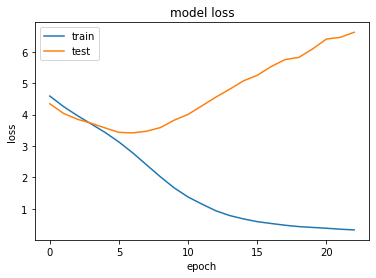

2nd CNN MODEL:


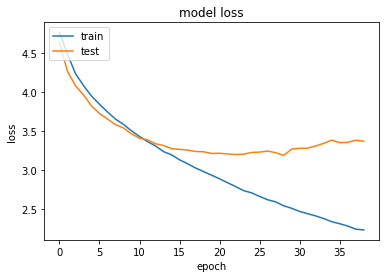

VGG16 MODEL: 


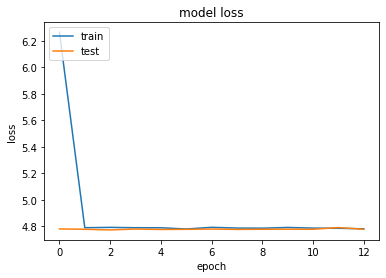

In [119]:
#Loss
print("1st CNN MODEL: ")
history_loss(wholehistory_cnn)
print("2nd CNN MODEL:")
history_loss(wholehistory_cnn2)
print("VGG16 MODEL: ")
history_loss(wholehistory_model)


1st CNN MODEL: 


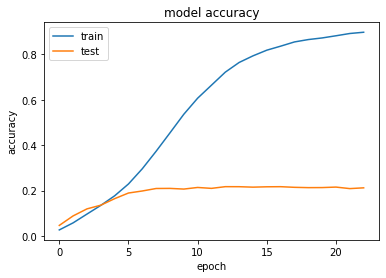

2nd CNN MODEL:


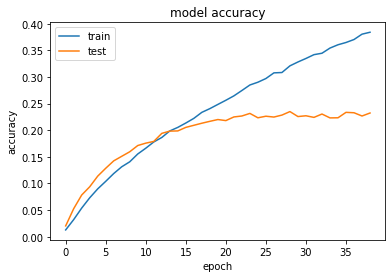

VGG16 MODEL: 


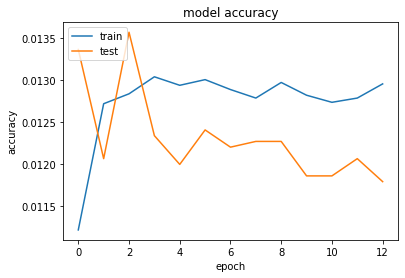

In [120]:
# Accuracy
print("1st CNN MODEL: ")
history_accuracy(wholehistory_cnn)
print("2nd CNN MODEL:")
history_accuracy(wholehistory_cnn2)
print("VGG16 MODEL: ")
history_accuracy(wholehistory_model)



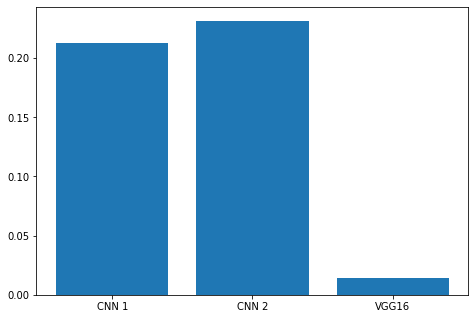

In [121]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
CNN = ['CNN 1','CNN 2', 'VGG16']
Test_Accuracy = [wholescore_cnn[1],wholescore_cnn2[1],wholescore_model[1]]
ax.bar(CNN,Test_Accuracy)
plt.show()

In [122]:
def plot_prediction_images(prediction):
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range (num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, prediction[i], test_labels, test_images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, prediction[i], test_labels)
    plt.tight_layout()
    plt.show()

In [123]:
def create_neural_network(MaxPoolNum=3,PoolSizeList=[(3,3),(3,3),(2,2)],ConvList=[2,2,3],KerSizes=[[(3,3),(3,3)],[(3,3),(3,3)],[(3,3),(3,3),(3,3)]],ConvArgList=[[32,32],[64,64],[128,128,256]],optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],rescaling=True,input_shape=input_shape,dropout_rate=0.75):
    model_temp = Sequential()
    if rescaling:
        model_temp.add(Rescaling(1./255, input_shape=input_shape))
    for k in range(MaxPoolNum):
        for i in range(ConvList[k]):
            if k==0 and i==0:
                model_temp.add(Conv2D(ConvArgList[k][i],kernel_size=KerSizes[k][i],activation='relu', input_shape=input_shape))
            else:
                model_temp.add(Conv2D(ConvArgList[k][i],kernel_size=KerSizes[k][i],activation='relu'))
        if k==0:
            model_temp.add(LayerNormalization())
        model_temp.add(MaxPooling2D(pool_size=PoolSizeList[k]))


    model_temp.add(Flatten())
    model_temp.add(Dense(num_classes*5, activation='relu'))
    model_temp.add(Dropout(dropout_rate))
    model_temp.add(Dense(num_classes, activation='softmax'))

    model_temp.compile(optimizer=optimizer,loss=loss,metrics=metrics)
    return model_temp

In [124]:
modeltry=create_neural_network()
modeltry.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 layer_normalization_3 (Laye  (None, 96, 96, 32)       64        
 rNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 30, 30, 64)      